=== DATA PREPROCESSING ===
Original data shape: (569, 33)
Data shape after dropping columns: (569, 31)
Checking for null values: False
Diagnosis distribution:
 diagnosis
B    357
M    212
Name: count, dtype: int64
Shape after outlier removal: (398, 31) (removed 171 outliers)
Training data shape: (278, 30)
Test data shape: (120, 30)

=== MODEL TRAINING ===

=== NAIVE BAYES ===
Training Accuracy: 0.9424
Test Accuracy: 0.9417
ROC AUC: 0.9467

=== LOGISTIC REGRESSION ===
Training Accuracy: 0.9856
Test Accuracy: 0.9750
ROC AUC: 0.9671

=== SVM ===
Training Accuracy: 0.9856
Test Accuracy: 0.9750
ROC AUC: 0.9671

=== KNN ===
Training Accuracy: 0.9568
Test Accuracy: 0.9667
ROC AUC: 0.9443

=== RANDOM FOREST ===
Training Accuracy: 1.0000
Test Accuracy: 0.9583
ROC AUC: 0.9040


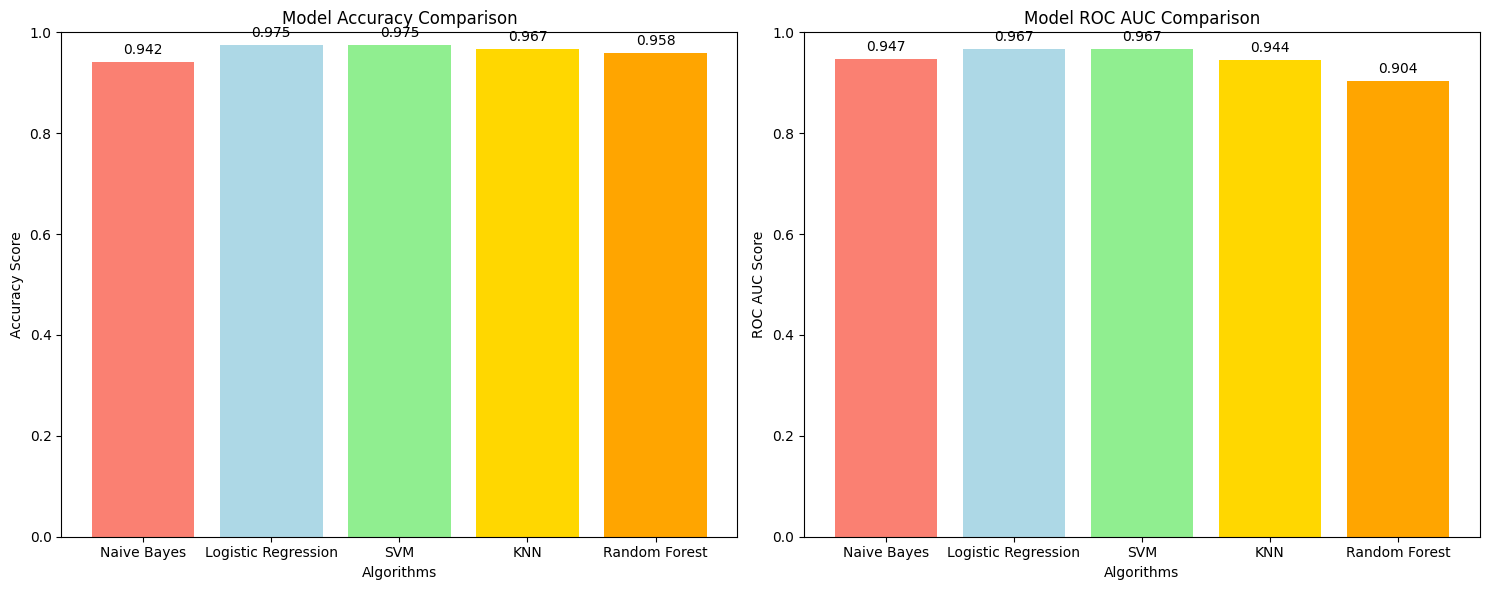


Best performing model: Logistic Regression (Accuracy: 0.9750)

INTERACTIVE BREAST CANCER PREDICTION INTERFACE



=== FEATURE IMPORTANCE ANALYSIS (Logistic Regression) ===

=== SAMPLE PREDICTIONS ===
Sample Benign Case Prediction:
  Naive Bayes: Benign
  Logistic Regression: Benign
  SVM: Benign
  KNN: Benign
  Random Forest: Benign

Sample Malignant Case Prediction:
  Naive Bayes: Malignant
  Logistic Regression: Malignant
  SVM: Malignant
  KNN: Malignant
  Random Forest: Malignant

SETUP COMPLETE!
Scroll up to use the interactive prediction tool.


In [4]:
# Enhanced Breast Cancer Prediction with Interactive User Input
# Run this in Google Colab

# Install required libraries (run this first in Colab)
# !pip install ipywidgets

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# For interactive widgets in Colab
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# read data
df = pd.read_csv('data.csv')

# Data preprocessing (your existing code)
print("=== DATA PREPROCESSING ===")
print("Original data shape:", df.shape)

# shuffle the data because data in series
df = df.sample(frac=1, random_state=42)

# drop the unnamed and id columns.
df = df.drop(columns=['Unnamed: 32', 'id'])

print("Data shape after dropping columns:", df.shape)
print("Checking for null values:", df.isnull().values.any())
print("Diagnosis distribution:\n", df['diagnosis'].value_counts())

# Outlier removal - exclude 'diagnosis' column for quantile calculation
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
inter_quartile_range = Q3 - Q1

# Apply outlier removal only to numeric columns
outlier_condition = ((df_numeric < (Q1 - (1.5 * inter_quartile_range))) |
                     (df_numeric > (Q3 + (1.5 * inter_quartile_range)))).any(axis=1)
df_out = df[~outlier_condition]
print(f"Shape after outlier removal: {df_out.shape} (removed {df.shape[0] - df_out.shape[0]} outliers)")

# Separate labels and features
X = df_out.drop(columns=['diagnosis'])
y = df_out['diagnosis']

# Convert the M to 1 and B to 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature scaling for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Model training and evaluation functions
def train_and_evaluate_models():
    """Train all models and return their performance metrics"""

    models = {
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(random_state=42),
        'SVM': SVC(gamma='auto', kernel='linear', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=9),
        'Random Forest': RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\n=== {name.upper()} ===")

        # Train model
        model.fit(X_train, y_train)
        trained_models[name] = model

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Metrics
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        results[name] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'roc_auc': roc_auc
        }

        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

    return results, trained_models

# Train models
print("\n=== MODEL TRAINING ===")
model_results, trained_models = train_and_evaluate_models()

# Visualization of model performance
def plot_model_comparison():
    """Plot model comparison charts"""
    model_names = list(model_results.keys())
    test_accuracies = [model_results[name]['test_accuracy'] for name in model_names]
    roc_aucs = [model_results[name]['roc_auc'] for name in model_names]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy plot
    colors = ['salmon', 'lightblue', 'lightgreen', 'gold', 'orange']
    bars1 = ax1.bar(model_names, test_accuracies, color=colors)
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy Score')
    ax1.set_xlabel('Algorithms')
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars1, test_accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    # ROC AUC plot
    bars2 = ax2.bar(model_names, roc_aucs, color=colors)
    ax2.set_title('Model ROC AUC Comparison')
    ax2.set_ylabel('ROC AUC Score')
    ax2.set_xlabel('Algorithms')
    ax2.set_ylim(0, 1)

    # Add value labels on bars
    for bar, roc in zip(bars2, roc_aucs):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{roc:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_model_comparison()

# Best model selection
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_accuracy'])
best_model = trained_models[best_model_name]
print(f"\nBest performing model: {best_model_name} (Accuracy: {model_results[best_model_name]['test_accuracy']:.4f})")

# Get feature importance for interpretation
feature_names = X.columns.tolist()

def get_feature_stats():
    """Get statistics for each feature to help with user input"""
    stats = {}
    for feature in feature_names:
        stats[feature] = {
            'min': df[feature].min(),
            'max': df[feature].max(),
            'mean': df[feature].mean(),
            'std': df[feature].std(),
            'malignant_mean': df[df['diagnosis'] == 'M'][feature].mean(),
            'benign_mean': df[df['diagnosis'] == 'B'][feature].mean()
        }
    return stats

feature_stats = get_feature_stats()

# Interactive prediction function
def predict_cancer_risk(user_inputs):
    """Predict cancer risk based on user inputs"""
    # Create a DataFrame with user inputs
    user_df = pd.DataFrame([user_inputs], columns=feature_names)

    # Scale the inputs using the same scaler
    user_scaled = scaler.transform(user_df)

    # Get predictions from all models
    predictions = {}
    probabilities = {}

    for name, model in trained_models.items():
        pred = model.predict(user_scaled)[0]
        predictions[name] = 'Malignant' if pred == 1 else 'Benign'

        # Get probability if available
        if hasattr(model, 'predict_proba'):
            prob = model.predict_proba(user_scaled)[0]
            probabilities[name] = {
                'Benign': prob[0],
                'Malignant': prob[1]
            }

    return predictions, probabilities

# Interactive widget interface
def create_interactive_interface():
    """Create interactive widgets for user input"""

    # Select key features for simplified input
    key_features = [
        'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
        'smoothness_mean', 'compactness_mean', 'concavity_mean',
        'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'
    ]

    # Create sliders for each key feature
    sliders = {}
    for feature in key_features:
        stats = feature_stats[feature]
        sliders[feature] = widgets.FloatSlider(
            value=stats['mean'],
            min=stats['min'],
            max=stats['max'],
            step=(stats['max'] - stats['min']) / 100,
            description=feature.replace('_', ' ').title()[:15] + ':',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='500px')
        )

    # Create remaining feature sliders (with default values)
    remaining_features = [f for f in feature_names if f not in key_features]
    for feature in remaining_features:
        stats = feature_stats[feature]
        sliders[feature] = widgets.FloatSlider(
            value=stats['mean'],
            min=stats['min'],
            max=stats['max'],
            step=(stats['max'] - stats['min']) / 100,
            description=feature.replace('_', ' ').title()[:15] + ':',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='500px')
        )

    # Predict button
    predict_button = widgets.Button(description="Predict Cancer Risk", button_style='info')
    output = widgets.Output()

    def on_predict_clicked(b):
        with output:
            clear_output()

            # Get user inputs
            user_inputs = {feature: slider.value for feature, slider in sliders.items()}

            # Make predictions
            predictions, probabilities = predict_cancer_risk(user_inputs)

            # Display results
            print("=" * 50)
            print("CANCER RISK PREDICTION RESULTS")
            print("=" * 50)

            # Count predictions
            malignant_count = sum(1 for pred in predictions.values() if pred == 'Malignant')
            benign_count = len(predictions) - malignant_count

            print(f"\nPrediction Summary:")
            print(f"Models predicting BENIGN: {benign_count}")
            print(f"Models predicting MALIGNANT: {malignant_count}")

            if malignant_count > benign_count:
                risk_level = "HIGH RISK"
                color = "🔴"
            elif malignant_count > 0:
                risk_level = "MODERATE RISK"
                color = "🟡"
            else:
                risk_level = "LOW RISK"
                color = "🟢"

            print(f"\nOverall Risk Assessment: {color} {risk_level}")

            print(f"\nDetailed Model Predictions:")
            for model_name, prediction in predictions.items():
                symbol = "⚠️" if prediction == "Malignant" else "✅"
                print(f"{symbol} {model_name}: {prediction}")

                if model_name in probabilities:
                    prob = probabilities[model_name]
                    print(f"   Benign: {prob['Benign']:.2%}, Malignant: {prob['Malignant']:.2%}")

            # Plot probability chart
            if probabilities:
                fig, ax = plt.subplots(figsize=(10, 6))

                models = list(probabilities.keys())
                benign_probs = [probabilities[model]['Benign'] for model in models]
                malignant_probs = [probabilities[model]['Malignant'] for model in models]

                x = np.arange(len(models))
                width = 0.35

                ax.bar(x - width/2, benign_probs, width, label='Benign', color='lightgreen', alpha=0.8)
                ax.bar(x + width/2, malignant_probs, width, label='Malignant', color='lightcoral', alpha=0.8)

                ax.set_xlabel('Models')
                ax.set_ylabel('Probability')
                ax.set_title('Cancer Risk Probability by Model')
                ax.set_xticks(x)
                ax.set_xticklabels(models, rotation=45)
                ax.legend()
                ax.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()

            print(f"\n⚠️  IMPORTANT DISCLAIMER:")
            print("This prediction is for educational purposes only.")
            print("Please consult healthcare professionals for medical advice.")
            print("Regular medical check-ups and professional diagnosis are essential.")

    predict_button.on_click(on_predict_clicked)

    # Layout
    main_features = widgets.VBox([sliders[f] for f in key_features[:5]])
    secondary_features = widgets.VBox([sliders[f] for f in key_features[5:]])

    # Option to show all features
    show_all_checkbox = widgets.Checkbox(description="Show all features (advanced)", value=False)
    all_features_box = widgets.VBox([sliders[f] for f in remaining_features])

    def toggle_features(change):
        if change['new']:
            all_features_box.layout.display = 'block'
        else:
            all_features_box.layout.display = 'none'

    show_all_checkbox.observe(toggle_features, names='value')
    all_features_box.layout.display = 'none'

    interface = widgets.VBox([
        widgets.HTML("<h2>🏥 Breast Cancer Risk Prediction Tool</h2>"),
        widgets.HTML("<p>Adjust the sliders below based on medical measurements:</p>"),
        widgets.HBox([main_features, secondary_features]),
        show_all_checkbox,
        all_features_box,
        predict_button,
        output
    ])

    return interface

# Display the interactive interface
print("\n" + "="*60)
print("INTERACTIVE BREAST CANCER PREDICTION INTERFACE")
print("="*60)

interface = create_interactive_interface()
display(interface)

# Additional analysis and insights
def show_feature_importance():
    """Show feature importance analysis"""
    if best_model_name == 'Random Forest':
        importance = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Most Important Features ({best_model_name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print("Top 10 Most Important Features:")
        for i, row in feature_importance_df.head(10).iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

print(f"\n=== FEATURE IMPORTANCE ANALYSIS ({best_model_name}) ===")
show_feature_importance()

# Sample test cases
def run_sample_predictions():
    """Run predictions on sample cases"""
    print("\n=== SAMPLE PREDICTIONS ===")

    # Sample benign case (using average benign values)
    benign_sample = {}
    malignant_sample = {}

    for feature in feature_names:
        benign_sample[feature] = feature_stats[feature]['benign_mean']
        malignant_sample[feature] = feature_stats[feature]['malignant_mean']

    print("Sample Benign Case Prediction:")
    predictions, _ = predict_cancer_risk(benign_sample)
    for model, pred in predictions.items():
        print(f"  {model}: {pred}")

    print("\nSample Malignant Case Prediction:")
    predictions, _ = predict_cancer_risk(malignant_sample)
    for model, pred in predictions.items():
        print(f"  {model}: {pred}")

run_sample_predictions()

print("\n" + "="*60)
print("SETUP COMPLETE!")
print("Scroll up to use the interactive prediction tool.")
print("="*60)